## Setting Up Your Python Environment

**To use a different virtual environment for this notebook:**

1. Press `Ctrl+Shift+P` to open the command palette
2. Type "Python: Select Interpreter"
3. Choose your venv's Python executable (usually in `venv\Scripts\python.exe`)

The notebook will automatically use the selected interpreter. No need to register the venv as a Jupyter kernel separately.

**Note:** Make sure your selected environment has all required packages installed, including `ipykernel` (see the cell below). The `ipykernel` package is required for Jupyter notebooks to work with your Python environment.


In [2]:
# Install all required packages for this notebook
# Only run this cell if packages are missing or need updating
# If using a virtual environment, make sure it's activated and selected as your Python interpreter first

%pip install ipykernel daft-pgm xarray numpy pandas matplotlib

  Using cached daft_pgm-0.1.4-py3-none-any.whl.metadata (1.5 kB)
Using cached daft_pgm-0.1.4-py3-none-any.whl (13 kB)
Note: you may need to restart the kernel to use updated packages.


# Multi-Dimensional Arrays for Decision Analysis


/opt/anaconda3/lib/python3.13/site-packages/daft/_core.py:848: RuntimeWarning: divide by zero encountered in scalar divide
  dxx2 = self.scale * 0.5 * np.abs(dx / dy) * (np.sign(dx) or 1.0)


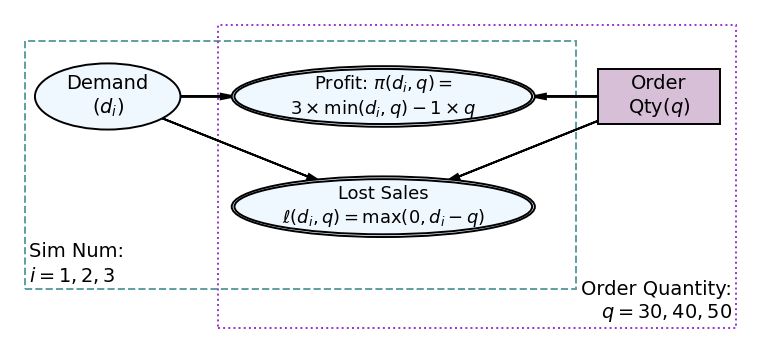

In [1]:
#@title A Full Decision Model
#| echo: false
#| include: false

import matplotlib.pyplot as plt
import pandas as pd
from functools import partial, partialmethod
import daft   ### %pip install -U git+https://github.com/daft-dev/daft.git
from numpy.random import default_rng
import numpy as np

class dag(daft.PGM):
    def __init__(self, *args, **kwargs):
        daft.PGM.__init__(self, *args, **kwargs)

    obsNode = partialmethod(daft.PGM.add_node, aspect = 2.2, fontsize = 10, plot_params = {'facecolor': 'cadetblue'})
    decNode = partialmethod(daft.PGM.add_node, aspect = 2.2, fontsize = 10, shape = "rectangle", plot_params = {'facecolor': 'thistle'})
    detNode = partialmethod(daft.PGM.add_node, aspect = 5.4, fontsize = 9.25, alternate = True, plot_params = {'facecolor': 'aliceblue'})
    latNode = partialmethod(daft.PGM.add_node, scale = 1.2, aspect = 2.2, fontsize = 10, plot_params = {'facecolor': 'aliceblue'})
    detNodeBig = partialmethod(daft.PGM.add_node, scale = 1.6, aspect = 2.25, fontsize = 10, alternate = True, plot_params = {'facecolor': 'aliceblue'})
    latNodeBig = partialmethod(daft.PGM.add_node, scale = 1.6, aspect = 2.2, fontsize = 10, plot_params = {'facecolor': 'aliceblue'})

pgm = dag(dpi = 300, alternate_style="outer")
pgm.latNode("d","Demand\n"+r"$(d_i)$",1,2)
pgm.decNode("q","Order\n" + r"Qty$(q)$",6,2)
pgm.detNode("pi","Profit: " + r"$\pi(d_i,q) =$" + "\n" + r"$3 \times \min(d_i,q) - 1 \times q$", 3.5,2)
pgm.detNode("l","Lost Sales\n" + r"$\ell(d_i,q) = \max(0,d_i-q)$", 3.5,1)
pgm.add_edge("d","pi")
pgm.add_edge("q","pi")
pgm.add_edge("d","l")
pgm.add_edge("q","l")
pgm.add_plate([0.25, 0.25, 5, 2.25], label = "Sim Num:\n" + r"$i = 1, 2, 3$",
              label_offset = (2,2), rect_params = dict({"fill": False, "linestyle": "dashed", "edgecolor": "cadetblue"}))
pgm.add_plate([2, -0.1, 4.7, 2.75], label = "Order Quantity:\n" + r"$q = 30, 40, 50$",
              label_offset = (2,2), position = "bottom right", rect_params = dict({"fill": False, "linestyle": "dotted", "edgecolor": "darkorchid"}))
pgm.show(dpi = 140)

Around the nodes, notice the new addition of rectangles,technically called _plates_.  

$$
\begin{aligned}
i &\equiv \textrm{Index for simulation draws. } i \in \{1, 2, 3\}\\
d_i &\equiv \textrm{Daily demand for newspapers, and}\\
d_i &\sim \textrm{Binomial}(n=200,p=0.2).\\
q &\equiv \textrm{Order quantity chosen by decision-maker, where}\\
q &\in \{30, 40, 50\} \qquad \textit{   (potentially good order qtys.)}.\\
\pi &\equiv \textrm{Daily profit is revenue minus expenses.}\\
\pi(d_i,q) &= 3 \times \min(d_i,q) - 1 \times q \qquad \textit{   (cannot sell more than ordered)}.\\
\ell &\equiv \textrm{Lost sales.  Unmet demand due to being out of stock.}\\
\ell(d_i,q) &= \max(0, d-q) \qquad \textit{   (lost sales cannot be negative)}.
\end{aligned}
$$

In [2]:
potentialCusts = 200
purchaseProb = 0.2

rng = default_rng(seed = 111)
numSims = 3

# create data frame to store simulated demand
newsDF = pd.DataFrame({"simNum": range(1, numSims+1),  # sequence of 1 to 100
                   "demand": rng.binomial(n = potentialCusts,
                                          p = purchaseProb,
                                          size = numSims)})

## google SEARCH PHRASE: get element-wise minimum of two columns in pandas dataframe
newsDF["profit_q40"] = 3 * np.minimum(newsDF.demand,40) - 1 * 40
newsDF["lostSales_q40"] = np.maximum(0,newsDF.demand - 40)

# view first few 5 rows of newsDF
newsDF.iloc[:5,:]

,simNum,demand,profit_q40,lostSales_q40
0,1,42,80,2
1,2,47,80,7
2,3,43,80,3


It will feel cumbersome to add more columns for each order quantity's profit and each quantity's lost sales into a dataframe.  There must be a better way to structure how we store this data.  

## The `xarray` Package

### `DataArray`:  In its simplest 1-dimensional form, a `DataArray` is just a collection of values, like the column of dataframe (`pandas.Series`) or a one-dimensional array of values (`numpy.ndarray`).  We can create a simple `DataArray` using its constructor function.

In [3]:
from numpy.random import default_rng
import numpy as np
import xarray as xr

rng = default_rng(seed = 111)  ## set random seed
demand = rng.binomial(n=200,p=0.2,size=3)   ## get demand values

## make data array
xr.DataArray(data = demand)

<xarray.DataArray (dim_0: 3)> Size: 24B
array([42, 47, 43])
Dimensions without coordinates: dim_0


*   dimension key-value pair `dim_0: 3` tells us that the cardinality of our
demand array is 3


In [4]:
## make data array with labelled dimension name
xr.DataArray(data = demand, dims = "draw")

<xarray.DataArray (draw: 3)> Size: 24B
array([42, 47, 43])
Dimensions without coordinates: draw

In [5]:
## explicit labeling of coordinates - must use name now to create dataset later
demandDA = xr.DataArray(data = demand, coords = {"draw": np.arange(3)+1}, name = "demand")
demandDA

<xarray.DataArray 'demand' (draw: 3)> Size: 24B
array([42, 47, 43])
Coordinates:
  * draw     (draw) int64 24B 1 2 3

Notice, we can drop the `dims` arguments as the dimension name is supplied in the dictionary object passed to the `coords` argument.

/opt/anaconda3/lib/python3.13/site-packages/daft/_core.py:848: RuntimeWarning: divide by zero encountered in scalar divide
  dxx2 = self.scale * 0.5 * np.abs(dx / dy) * (np.sign(dx) or 1.0)


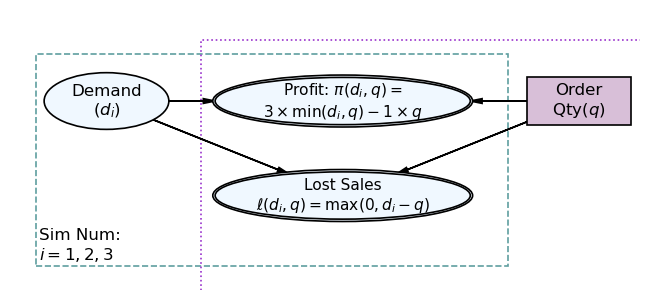

In [6]:
#@title Repeating the graphical model
pgm.show(dpi=120)

In [7]:
## creating a DataArray of order quantities - must use name now to create dataset later
orderDA = xr.DataArray(data = [30, 40, 50],
                       coords = {"orderQtyIndex": [30,40,50]},
                       name = "orderQty")
orderDA

<xarray.DataArray 'orderQty' (orderQtyIndex: 3)> Size: 24B
array([30, 40, 50])
Coordinates:
  * orderQtyIndex  (orderQtyIndex) int64 24B 30 40 50

## Merge the two data arrays into a dataset.

In [8]:
# create dataset by combining data arrays
newsvDS = xr.merge([demandDA,orderDA])
newsvDS

<xarray.Dataset> Size: 96B
Dimensions:        (draw: 3, orderQtyIndex: 3)
Coordinates:
  * draw           (draw) int64 24B 1 2 3
  * orderQtyIndex  (orderQtyIndex) int64 24B 30 40 50
Data variables:
    demand         (draw) int64 24B 42 47 43
    orderQty       (orderQtyIndex) int64 24B 30 40 50

Our `Dataset` container now has the dimensions implied by the plate indices in @fig-newsvGM2, namely `draw: 3  orderQty: 3`.  In math terms we have two sets, one is a set of demand draws where cardinality $|D|=3$; the other a set of order quantities with cardinality $|Q|=3$.  Thus, the set of all ordered pairs $(d_i,q)$ to be used for calculation of profit and lost sales will have cardinality $|D| \times |Q| = 9$.  Thus, our simulation of potential  $\pi(d_i,q)$ and $\ell(d_i,q)$ values will each have 9 elements.

## Seven mental models of dataset manipulation

The seven most important ways we might want to manipulate a data array or dataset is to:

1. Assign: `.assign()` or `assign_coords()`: Add data variables with broadcasting and array math.  (Can also use dict-like methods)
2. Subset: `.sel()` or `.where()` subset a data array or dataset based on coordinates or data values, respectively.
3. Drop: `.drop_vars()` or `.drop_dims()`: Remove an explicit list of data variables or remove all data variables indexed by a particular dimension.
4. Sort: `.sortby()` sorts or arranges a data array or dataset based on data values or coordinate values.
5. Aggregate: See the [xarray documentation](https://docs.xarray.dev/en/stable/api.html?highlight=aggregation#) for a list of aggregation functions.  These functions will collapse all the data of a given dimension; for example one can collapse a time dimension using the `mean()` aggregation method to get the average value for all of time.
6. Split-Apply-Combine: `.groupby()` and `DatasetGroupBy.foo()` are usually used in combination to 1) _split_ the dataset into groups based on levels of a variable, 2) _apply_ a function (e.g. `foo()`) to each group's dataset individually, and then 3) _combine_ the modified datasets. See the [xarray documentation](https://docs.xarray.dev/en/stable/api.html?highlight=Groupby#groupby-objects) for more details.
7. Merge(join): Getting information from two datasets to intelligently combine.

### 1 - Assign: Adding Data Arrays



In [9]:
(  ## open parenthesis to start readable code
    newsvDS
    .assign(soldNewspapers = np.minimum(newsvDS.demand,newsvDS.orderQty))
) ## close parenthesis finishes the "method chaining"

<xarray.Dataset> Size: 168B
Dimensions:         (draw: 3, orderQtyIndex: 3)
Coordinates:
  * draw            (draw) int64 24B 1 2 3
  * orderQtyIndex   (orderQtyIndex) int64 24B 30 40 50
Data variables:
    demand          (draw) int64 24B 42 47 43
    orderQty        (orderQtyIndex) int64 24B 30 40 50
    soldNewspapers  (draw, orderQtyIndex) int64 72B 30 40 42 30 40 47 30 40 43

In [10]:
#| eval: false
(  ## open parenthesis to start readable code
    newsvDS
    .assign(soldNewspapers = np.minimum(newsvDS.demand,newsvDS.orderQty))
    .assign(revenue = 3 * newsvDS.soldNewspapers)
) ## close parenthesis finishes the "method chaining"

AttributeError: 'Dataset' object has no attribute 'soldNewspapers'

The above code will yield an error:

```
AttributeError: 'Dataset' object has no attribute 'soldNewspapers'
```

The last assignment apparently does not have visibility into the newly created data for `soldNewspapers`.  To pass the _current state_ of the dataset to the `.assign()` method, we use a `lambda` function.  The `lambda` function has syntax `lambda arguments : expression` where `lambda` is a keyword telling python to expect an argument (or arguments), followed by a colon (`:`), and then an expression for what will be returned by the function..  Here is updated code that works:

In [11]:
(  ## open parenthesis to start readable code
    newsvDS
    .assign(soldNewspapers = np.minimum(newsvDS.demand,newsvDS.orderQty))
    .assign(revenue = lambda DS: 3 * DS.soldNewspapers)
) ## use lambda function to get current state of dataset in chain

<xarray.Dataset> Size: 240B
Dimensions:         (draw: 3, orderQtyIndex: 3)
Coordinates:
  * draw            (draw) int64 24B 1 2 3
  * orderQtyIndex   (orderQtyIndex) int64 24B 30 40 50
Data variables:
    demand          (draw) int64 24B 42 47 43
    orderQty        (orderQtyIndex) int64 24B 30 40 50
    soldNewspapers  (draw, orderQtyIndex) int64 72B 30 40 42 30 40 47 30 40 43
    revenue         (draw, orderQtyIndex) int64 72B 90 120 126 90 ... 90 120 129

## YOUR TURN:  Use `assign` to add a lost sales data variable to the dataset.  Modify the below.

In [12]:
newsvDS = (newsvDS
            .assign(soldNewspapers = np.minimum(newsvDS.demand,newsvDS.orderQty))
            .assign(revenue = lambda DS: 3 * DS.soldNewspapers)
            .assign(expense = 1 * newsvDS.orderQty)
            .assign(profit = lambda DS: DS.revenue - DS.expense)
)

(newsvDS
 .to_dataframe())  #dataframe for printing

demand  orderQty  soldNewspapers  revenue  expense  profit
draw orderQtyIndex                                                            
1    30                 42        30              30       90       30      60
     40                 42        40              40      120       40      80
     50                 42        50              42      126       50      76
2    30                 47        30              30       90       30      60
     40                 47        40              40      120       40      80
     50                 47        50              47      141       50      91
3    30                 43        30              30       90       30      60
     40                 43        40              40      120       40      80
     50                 43        50              43      129       50      79

Note, one can also add columns directly using dict-like indexing when chains of operations are not required.  The following code would work similarly to what we did earlier:

In [13]:
newsvDS["lostSales"] = np.maximum(0, newsvDS.demand - newsvDS.orderQty)

### 2 - Select a subset of the data array or dataset

Syntax of help documentation is often `packagename.Class.method`.  Let's find the `sel` method in the xarray documentation. (https://docs.xarray.dev/en/stable/user-guide/indexing.html)

In [14]:
# select a particular value for a dimension
newsvDS.sel(orderQtyIndex = 30) # returns 1-d dataset

<xarray.Dataset> Size: 168B
Dimensions:         (draw: 3)
Coordinates:
  * draw            (draw) int64 24B 1 2 3
    orderQtyIndex   int64 8B 30
Data variables:
    demand          (draw) int64 24B 42 47 43
    orderQty        int64 8B 30
    soldNewspapers  (draw) int64 24B 30 30 30
    revenue         (draw) int64 24B 90 90 90
    expense         int64 8B 30
    profit          (draw) int64 24B 60 60 60
    lostSales       (draw) int64 24B 12 17 13

`xarray` uses the `slice()` function to select ranges of coordinate values, following the pandas convention. **Important:** Unlike standard Python slicing (which excludes the end point), `slice()` in xarray is **inclusive of both start and end points**. For example, `slice(36, 58)` includes both 36 and 58 in the result.

In [15]:
# slicing returns all values inside the range (inclusive)
# as long as the index labels are monotonic increasing
newsvDS.sel(orderQtyIndex = slice(36,58))

<xarray.Dataset> Size: 288B
Dimensions:         (draw: 3, orderQtyIndex: 2)
Coordinates:
  * draw            (draw) int64 24B 1 2 3
  * orderQtyIndex   (orderQtyIndex) int64 16B 40 50
Data variables:
    demand          (draw) int64 24B 42 47 43
    orderQty        (orderQtyIndex) int64 16B 40 50
    soldNewspapers  (draw, orderQtyIndex) int64 48B 40 42 40 47 40 43
    revenue         (draw, orderQtyIndex) int64 48B 120 126 120 141 120 129
    expense         (orderQtyIndex) int64 16B 40 50
    profit          (draw, orderQtyIndex) int64 48B 80 76 80 91 80 79
    lostSales       (draw, orderQtyIndex) int64 48B 2 0 7 0 3 0

Slicing returns a smaller dataset or data array based on coordinates, but often we want a smaller dataset based on data values.  In these cases, we apply the `.where()` method where the argument is some logical condition for which data to keep:

In [16]:
# need to explicitly use DataSet.DataArray syntax for
# filtering out rows that do not meet condition
newsvDS.assign(lostSales = lambda DS: DS.revenue - DS.expense).where(newsvDS.lostSales > 0)

<xarray.Dataset> Size: 552B
Dimensions:         (draw: 3, orderQtyIndex: 3)
Coordinates:
  * draw            (draw) int64 24B 1 2 3
  * orderQtyIndex   (orderQtyIndex) int64 24B 30 40 50
Data variables:
    demand          (draw, orderQtyIndex) float64 72B 42.0 42.0 nan ... 43.0 nan
    orderQty        (orderQtyIndex, draw) float64 72B 30.0 30.0 30.0 ... nan nan
    soldNewspapers  (draw, orderQtyIndex) float64 72B 30.0 40.0 nan ... 40.0 nan
    revenue         (draw, orderQtyIndex) float64 72B 90.0 120.0 ... 120.0 nan
    expense         (orderQtyIndex, draw) float64 72B 30.0 30.0 30.0 ... nan nan
    profit          (draw, orderQtyIndex) float64 72B 60.0 80.0 nan ... 80.0 nan
    lostSales       (draw, orderQtyIndex) float64 72B 60.0 80.0 nan ... 80.0 nan

Often times, the `lambda` syntax for anonymous functions gets used to pass in the dataset name:

In [17]:
(
    newsvDS.where(lambda x: x.lostSales > 0, drop = True)
    .to_dataframe()  #convert to pandas dataframe for printing
    .dropna() # pandas method to remove NaN rows
 )

demand  orderQty  soldNewspapers  revenue  expense  \
draw orderQtyIndex                                                       
1    30               42.0      30.0            30.0     90.0     30.0   
     40               42.0      40.0            40.0    120.0     40.0   
2    30               47.0      30.0            30.0     90.0     30.0   
     40               47.0      40.0            40.0    120.0     40.0   
3    30               43.0      30.0            30.0     90.0     30.0   
     40               43.0      40.0            40.0    120.0     40.0   

                    profit  lostSales  
draw orderQtyIndex                     
1    30               60.0       12.0  
     40               80.0        2.0  
2    30               60.0       17.0  
     40               80.0        7.0  
3    30               60.0       13.0  
     40               80.0        3.0

## YOUR TURN:  
Experiment with omitting the `pandas.DataFrame.dropna` method from the above.  What's different.   



In [ ]:
## experiment here:



### 3 - Drop Dimensions

The `drop_dims()` method returns a new object by dropping a full dimension from a dataset along with any variables whose coordinates rely on that dimension.

In [18]:
newsvDS.drop_dims("orderQtyIndex")

<xarray.Dataset> Size: 48B
Dimensions:  (draw: 3)
Coordinates:
  * draw     (draw) int64 24B 1 2 3
Data variables:
    demand   (draw) int64 24B 42 47 43

Above, the order quantity dimension is dropped along with all the data variables whose value depended on order quantity: `orderQty`, `soldNewspapers`, `revenue`, `expense`, `profit`, and `lostSales`.

If you want to just drop some of the data variables, you use `drop_vars()`:

In [ ]:
newsvDS.drop_vars(["revenue","expense"])

### 4 - Sort a data array or dataset based on data values or data values.

We will typically want dataframe-like reports generated out of `xarray` as a last step in data manipulation.  We will rely on `pandas.DataFrame.sort_values()` to help us for this mental model.

In [19]:
(newsvDS
 .to_dataframe()
 .sort_values("profit"))

demand  orderQty  soldNewspapers  revenue  expense  \
draw orderQtyIndex                                                       
1    30                 42        30              30       90       30   
2    30                 47        30              30       90       30   
3    30                 43        30              30       90       30   
1    50                 42        50              42      126       50   
3    50                 43        50              43      129       50   
1    40                 42        40              40      120       40   
3    40                 43        40              40      120       40   
2    40                 47        40              40      120       40   
     50                 47        50              47      141       50   

                    profit  lostSales  
draw orderQtyIndex                     
1    30                 60         12  
2    30                 60         17  
3    30                 60         13  
1    50                 76          0  
3    50                 79          0  
1    40                 80          2  
3    40                 80          3  
2    40                 80          7  
     50                 91          0

## YOUR TURN:
Using `.sort_values("profit", ascending = True)` reverse the sort order so maximum profit is first.

In [ ]:
# Experiment Here:





### 5 - Aggregation

See the `xarray` documentation at https://docs.xarray.dev/en/stable/api.html#id6 for a complete list of aggregation functions.

1) Aggregate the information in a data array.
2) Assign the output of the aggregation to a new data array in a pre-existing dataset.

In [ ]:
## collapse the 100 draws into 1 summary statistic
(
    newsvDS
    .profit
    .mean(dim = "draw")
)

Notice, this returns a `DataArray` object.  We will then keep our data and summary statistics together in one dataset by adding the array back to the original dataset using `assign()`.  Here the two-step workflow is demonstrated to return expected profit and expected lost sales for each order quantity:

In [ ]:
## create mean summary stats
(
    newsvDS
    .assign(expProfit = newsvDS.profit.mean(dim="draw"))
    .assign(expLossSales = newsvDS.lostSales.mean(dim="draw"))
)

Feel free to play around with these other frequently-used aggregation functions include `count`, `first`, `last`, `max`, `mean`, `median`, `min`, `quantile`, and `sum.`

### 6 - Split-Apply-Combine

See the [xarray documentation](https://docs.xarray.dev/en/stable/api.html?highlight=Groupby#groupby-objects) for more details using split-apply-combine:



In [ ]:
## find average profit by orderQty
## see docuemntation here: https://docs.xarray.dev/en/stable/generated/xarray.core.groupby.DatasetGroupBy.mean.html
(
    newsvDS
    .get("profit")
    .groupby("orderQtyIndex")
    .mean(...)
).to_dataframe()

## YOUR TURN
Find the maximum lost sales by order quantity.

In [ ]:
# Code Here:

### 7 - Merge(join):

The `merge()` function combines two or more datasets by aligning them along shared dimensions and coordinates. This is useful when you have related data in separate datasets that you want to combine into one.

**Example:** Suppose we have supplier cost information in a separate dataset and want to merge it with our existing newspaper vendor dataset:

In [ ]:
# Create a dataset with supplier cost information per order quantity
supplierDS = xr.Dataset({
    "unitCost": (["orderQtyIndex"], [0.95, 0.90, 0.85]),  # bulk discount: larger orders get lower unit cost
    "shippingCost": (["orderQtyIndex"], [5, 8, 10])  # shipping increases with order size
}, coords={"orderQtyIndex": [30, 40, 50]})

supplierDS


In [ ]:
# Merge the supplier dataset with the existing newsvDS dataset
# xarray automatically aligns on shared coordinates (orderQtyIndex in this case)
combinedDS = xr.merge([newsvDS, supplierDS])

combinedDS


In [ ]:
# Now we can use the merged data to calculate profit with the new cost structure
# For example, recalculate profit using the supplier's unit cost instead of the fixed $1 cost
(
    combinedDS
    .assign(adjustedExpense = lambda DS: DS.unitCost * DS.orderQty + DS.shippingCost)
    .assign(adjustedProfit = lambda DS: DS.revenue - DS.adjustedExpense)
    .to_dataframe()
    .loc[:, ["orderQtyIndex", "draw", "profit", "adjustedProfit"]]
    .head(10)
)


**Key points about `merge()`:**

- `merge()` automatically aligns datasets on shared coordinates (in this case, `orderQtyIndex`)
- Variables from both datasets are combined into a single dataset
- If datasets have different dimensions, `merge()` will broadcast appropriately
- The merged dataset contains all variables from all input datasets

This is particularly useful when combining data from different sources or when adding new variables to an existing analysis.
